In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
# Create an EV class with the following attributes:
# - Brand
# - Model
# - Battery type
# - Battery size
# - Charging Efficiency
# - Discharging Efficiency
# - Energy per km
# - SOC min
# - SOC max
# - Probability in population - this is the probability that a car of this type will be chosen from the population

class EV:
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population):
        self.brand = brand
        self.model = model
        self.battery_type = battery_type
        self.battery_size = battery_size
        self.charging_efficiency = charging_efficiency if charging_efficiency <= 1 or charging_efficiency >= 0 else 0.9
        self.discharging_efficiency = discharging_efficiency if discharging_efficiency <= 1 or discharging_efficiency >= 0 else 0.9
        self.energy_per_km = energy_per_km
        self.soc_min = soc_min if soc_min >= 0.0 else 0.0
        self.soc_max = soc_max if soc_max <= 1.0 else 1.0
        self.probability_in_population = probability_in_population if probability_in_population <= 1.0 else 1.0


# Extend the class to create drivable EVs
class DrivableEV(EV):

    # __init__ method is inherited from EV class, extended with the state of charge. Creates the following attributes:
    # - State of Charge
    # - List of trips
    # - Current trip
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, initial_soc=None):
        super().__init__(brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population)

        # SOC variables
        self.soc = [initial_soc]
        self.current_soc = initial_soc

        # List of trips and current trip
        self.trips = []
        self.current_trip = None

        # Information about the charging stations
        self.current_charging_station = None


    # Format the print
    def __repr__(self):
        return f"{self.brand} {self.model} with {self.battery_size} kWh battery"

    # Create a method to add a trip to the EV
    def add_trip(self, trip):
        self.trips.append(trip)
        self.current_trip = trip


    # Create a method to charge the EV
    def charge(self, charge_amount):
        self.current_soc += charge_amount * self.charging_efficiency

        if self.current_soc > self.battery_size:
            self.current_soc = self.battery_size


    # Create a method to discharge the EV
    def discharge(self, discharge_amount):
        self.current_soc -= discharge_amount * self.discharging_efficiency

        if self.current_soc < 0:
            self.current_soc = 0

In [3]:
# Create a list of EVs to use in the simulation

EVs = [EV(brand='Nissa', model='Leaf', battery_type='BEV', battery_size=59,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.16, energy_per_km=0.17, soc_min=0.7, soc_max=1.0),
       EV(brand='Tesla', model='Model 3', battery_type='BEV', battery_size=95,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.13, energy_per_km=0.18, soc_min=0.7, soc_max=1.0),
       EV(brand='Peugeot', model='e-Expert', battery_type='BEV', battery_size=68,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.26, soc_min=0.7, soc_max=1.0),
       EV(brand='Renault', model='Zoe', battery_type='BEV', battery_size=52,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.17, soc_min=0.7, soc_max=1.0),
       EV(brand='Jaguar', model='I-Pace', battery_type='BEV', battery_size=85,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.09, energy_per_km=0.22, soc_min=0.7, soc_max=1.0),
       EV(brand='Mercedes', model='E300', battery_type='PHEV', battery_size=13.5,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.18, soc_min=0.7, soc_max=1.0),
       EV(brand='BMW', model='530e', battery_type='PHEV', battery_size=70.2,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.16, soc_min=0.7, soc_max=1.0),
       EV(brand='Audi Q4', model='e-tron', battery_type='PHEV', battery_size=55,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.07, energy_per_km=0.17, soc_min=0.7, soc_max=1.0),
       EV(brand='Hyundai', model='Kauai', battery_type='BEV', battery_size=74,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.06, energy_per_km=0.192, soc_min=0.7, soc_max=1.0),
       EV(brand='Volvo', model='XC40', battery_type='PHEV', battery_size=78,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.176, soc_min=0.7, soc_max=1.0),
       EV(brand='Wolkswagen', model='ID.3', battery_type='PHEV', battery_size=58,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.155, soc_min=0.7, soc_max=1.0),
       EV(brand='Others', model='Others', battery_type='PEV', battery_size=20,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.03, energy_per_km=0.2, soc_min=0.7, soc_max=1.0)]

# Print the sum of the probabilities in the population of EVs
sum_of_probabilities = 0
for ev in EVs:
    sum_of_probabilities += ev.probability_in_population
print(sum_of_probabilities)

1.0


In [4]:
# Define a Trip class, that will assign a trip to an EV. Has the following parameters:
# - EV
# - Trip length
# - Trip start time (can be a range)
# - Trip end time (can be a range)
# - Trip start SOC
# - Trip end SOC
# - Trip energy consumption
# - Trip stops

class Trip:
    def __init__(self, trip_length, trip_start_time, trip_end_time, trip_duration):
        self.ev = None
        self.trip_length = trip_length
        self.trip_start_time = trip_start_time
        self.trip_end_time = trip_end_time
        self.trip_duration = trip_duration


class DrivableTrip(Trip):
    # Init method is the same as Trip class
    def __init__(self, trip_length, trip_start_time, trip_end_time, trip_duration):
        super().__init__(trip_length, trip_start_time, trip_end_time, trip_duration)

        # Information about the trip
        self.trip_energy_consumption = None
        self.trip_required_soc = None
        self.ev_battery_size = None
        self.trip_stops = []

    # Formatted print method
    def __repr__(self):
        return f'Trip length: {self.trip_length} km, trip start time: {self.trip_start_time}, ' \
               f'trip end time: {self.trip_end_time}, trip energy consumption: {self.trip_energy_consumption} kWh, ' \
               f'trip required SOC: {self.trip_required_soc} %, trip stops: {self.trip_stops}'

    # Create a method to calculate the trip energy consumption
    def calculate_trip_energy_consumption(self):
        self.trip_energy_consumption = self.trip_length * self.ev.energy_per_km

    # Create a method to calculate the trip required SOC
    def calculate_trip_required_soc(self):
        self.trip_required_soc = self.trip_energy_consumption / self.ev.battery_size

    # Create a method to assign the battery size of the EV to the trip
    def assign_ev_battery_size(self):
        self.ev_battery_size = self.ev.battery_size

    # Create a method to add stops to the trip
    def add_stop(self, stop):
        self.trip_stops.append(stop)

In [5]:
# Define a Charging Station class, that will charge the EVs. Has the following parameters:
# - Charging station name
# - Charging station location
# - Charging station type
# - Charging station power
# - Charging station efficiency
# - Charging station availability
# - Charging station cost

class ChargingStation:
    def __init__(self, charging_station_name, charging_station_location, charging_station_type, charging_station_power, charging_station_efficiency, charging_station_availability, charging_station_cost):
        self.charging_station_name = charging_station_name
        self.charging_station_location = charging_station_location
        self.charging_station_type = charging_station_type
        self.charging_station_power = charging_station_power
        self.charging_station_efficiency = charging_station_efficiency
        self.charging_station_availability = charging_station_availability
        self.charging_station_cost = charging_station_cost


In [6]:
# Define an Aggregator class, that will aggregate the trips and EVs. Has the following parameters:
# - EVs
# - Trips
# - Number of EVs

class Aggregator:
    def __init__(self, evs, trips, number_of_evs):
        self.evs = evs
        self.trips = trips
        self.number_of_evs = number_of_evs
        self.population = None
        self.assigned_evs = []

    # Add an EV to the fleet
    def add_ev(self, ev):
        self.evs.append(ev)

    # Assign a trip to an EV
    def assign_trip(self, ev, trip):
        ev.add_trip(trip)

    # Assign a charging station to an EV, and charge the EV if:
    # - The charging station is available
    # - The charging station is of the correct type
    # - The charging station has enough power to charge the EV
    def assign_charging_station(self, ev, charging_station):
        if charging_station.charging_station_availability == True and charging_station.charging_station_type == ev.battery_type and charging_station.charging_station_power >= ev.battery_size:
            ev.current_charging_station = charging_station
            ev.charge(charging_station.charging_station_power)
            charging_station.charging_station_availability = False


    # Create the population of DrivableEVs according to NumPy's random.choice
    def create_population(self):
        population_choice = np.random.choice(self.evs, self.number_of_evs,
                                             p=[ev.probability_in_population for ev in self.evs])

        # Create a list of DrivableEVs
        self.population = [DrivableEV(ev.brand, ev.model, ev.battery_type, ev.battery_size,
                                      ev.charging_efficiency, ev.discharging_efficiency,
                                      ev.energy_per_km, ev.soc_min, ev.soc_max,
                                      ev.probability_in_population,
                                      initial_soc=np.round(np.random.uniform(ev.soc_min,
                                                                             ev.soc_max, 1)[0], 2))
                           for ev in population_choice]


    # Create DrivableTrips with a gamma distribution for the trip length
    def create_trips(self, n_trips, start_period, end_period, avg_speed):

        # Create a gamma distribution for the trip length
        shape, scale = 41.*.035, 41.*2
        trip_lengths = np.round(np.random.gamma(shape, scale, n_trips), 2)

        # Create the DrivableTrips
        for trip in range(n_trips):
            # Calculate trip duration based on trip length and average speed
            trip_duration = np.ceil(trip_lengths[trip] / avg_speed)

            # Create a trip starting time
            trip_start_time = np.random.randint(start_period, end_period)
            trip_start_time = trip_start_time if trip_start_time + trip_duration <= end_period else trip_start_time - trip_duration

            # Create a trip ending time
            trip_end_time = trip_start_time + trip_duration

            # Create the DrivableTrip object
            drivable_trip = DrivableTrip(trip_lengths[trip], trip_start_time, trip_end_time, trip_duration)
            self.trips.append(drivable_trip)


    # Assign the larger trips to the EVs with larger battery sizes with a greater probability
    def assign_trips(self):
        # Create a copy of the population
        population_copy = copy.deepcopy(self.population)

        # Assigned EVs and Trips
        assigned_evs = []

        # Create a list with the probabilities of the EVs to get a trip
        probabilities = [ev.battery_size / sum([ev.battery_size for ev in self.population]) for ev in population_copy]

        # Assign the trips to the EVs
        for trip in self.trips:
            # Choose an EV from the population
            ev = np.random.choice(population_copy, 1, p=probabilities)[0]

            # Assign the trip to the EV
            trip.ev = ev
            trip.calculate_trip_energy_consumption()
            trip.calculate_trip_required_soc()
            trip.assign_ev_battery_size()

            # Add the trip to the EV
            ev.add_trip(trip)

            # Calculate the trip energy consumption and required SOC
            trip.calculate_trip_energy_consumption()
            trip.calculate_trip_required_soc()

            # Remove the EV from the population
            population_copy.remove(ev)

            self.assigned_evs.append(ev)

            # Recalculate the probabilities
            probabilities = [ev.battery_size / sum([ev.battery_size for ev in population_copy]) for ev in population_copy]

            # If the population is empty, break the loop
            if len(population_copy) == 0:
                break


    # Create a DataFrame of the population
    def population_dataframe(self):
        # Create a DataFrame of the population
        population_dataframe = pd.DataFrame([ev.__dict__ for ev in self.population])

        # Return the DataFrame
        return population_dataframe


    # Create a DataFrame of assigned EVs
    def assigned_evs_dataframe(self):
        # Create a DataFrame of the population
        assigned_evs_dataframe = pd.DataFrame([ev.__dict__ for ev in self.assigned_evs])

        # Return the DataFrame
        return assigned_evs_dataframe

    # Create a DataFrame of assigned Trips
    def assigned_trips_dataframe(self):
        # Create a DataFrame of the population
        assigned_trips_dataframe = pd.DataFrame([trip.__dict__ for trip in self.trips])

        # Return the DataFrame
        return assigned_trips_dataframe

In [7]:
# Create an Aggregator object
aggregator = Aggregator(EVs, [], 100)

# Create the population of EVs
aggregator.create_population()

# Create the trips
aggregator.create_trips(n_trips=100,
                        start_period=0,
                        end_period=24,
                        avg_speed=60)
aggregator.assign_trips()

In [11]:
# Print the population
#aggregator.population_dataframe().to_csv("C:/Users/cindy/OneDrive - Universidade de Lisboa/Python/file_population.csv")
aggregator.population_dataframe()

,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,soc,current_soc,trips,current_trip,current_charging_station
0,Tesla,Model 3,BEV,75.0,0.9,0.9,0.2,0.7,1.0,0.13,[0.94],0.94,[],None,None
1,Mercedes,E300,PHEV,135.0,0.9,0.9,0.2,0.7,1.0,0.08,[0.97],0.97,[],None,None
2,Renault,Zoe,BEV,41.0,0.9,0.9,0.2,0.7,1.0,0.10,[0.74],0.74,[],None,None
3,BMW,530e,PHEV,120.0,0.9,0.9,0.2,0.7,1.0,0.08,[0.74],0.74,[],None,None
4,Jaguar,I-Pace,BEV,90.0,0.9,0.9,0.2,0.7,1.0,0.09,[0.94],0.94,[],None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Tesla,Model 3,BEV,75.0,0.9,0.9,0.2,0.7,1.0,0.13,[0.8],0.80,[],None,None
96,Renault,Zoe,BEV,41.0,0.9,0.9,0.2,0.7,1.0,0.10,[0.97],0.97,[],None,None
97,Tesla,Model 3,BEV,75.0,0.9,0.9,0.2,0.7,1.0,0.13,[0.76],0.76,[],None,None
98,Tesla,Model 3,BEV,75.0,0.9,0.9,0.2,0.7,1.0,0.13,[0.76],0.76,[],None,None


In [14]:
# Print the trips
#aggregator.assigned_trips_dataframe().to_csv("C:/Users/cindy/OneDrive - Universidade de Lisboa/Python/file_trips.csv")
aggregator.assigned_trips_dataframe()


,ev,trip_length,trip_start_time,trip_end_time,trip_duration,trip_energy_consumption,trip_required_soc,ev_battery_size,trip_stops
0,Others Others with 20 kWh battery,41.38,11.0,12.0,1.0,8.276,0.413800,20.0,[]
1,Renault Zoe with 41 kWh battery,335.81,13.0,19.0,6.0,67.162,1.638098,41.0,[]
2,Tesla Model 3 with 75 kWh battery,55.17,16.0,17.0,1.0,11.034,0.147120,75.0,[]
3,Jaguar I-Pace with 90 kWh battery,138.86,3.0,6.0,3.0,27.772,0.308578,90.0,[]
4,Mercedes E300 with 135 kWh battery,99.74,16.0,18.0,2.0,19.948,0.147763,135.0,[]
...,...,...,...,...,...,...,...,...,...
95,BMW i3 with 42 kWh battery,270.64,0.0,5.0,5.0,54.128,1.288762,42.0,[]
96,Nissa Leaf with 40 kWh battery,276.24,18.0,23.0,5.0,55.248,1.381200,40.0,[]
97,Mitshubishi Outlander with 12 kWh battery,209.18,17.0,21.0,4.0,41.836,3.486333,12.0,[]
98,Renault Zoe with 41 kWh battery,530.59,14.0,23.0,9.0,106.118,2.588244,41.0,[]


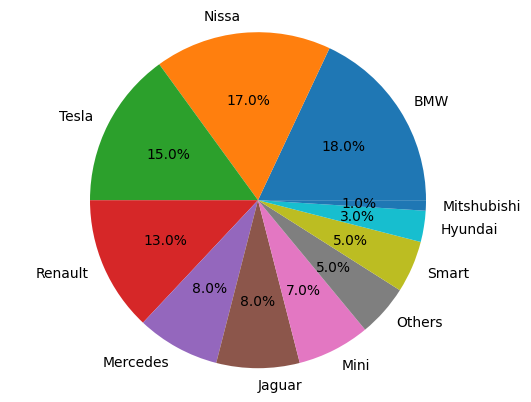

In [9]:
# Plot the population brand in a pie chart

# Values of each group
brand_values = aggregator.population_dataframe()['brand'].value_counts()
plt.pie(brand_values, labels=brand_values.index, autopct='%1.1f%%')

# View the plot
plt.axis('equal')
plt.show()

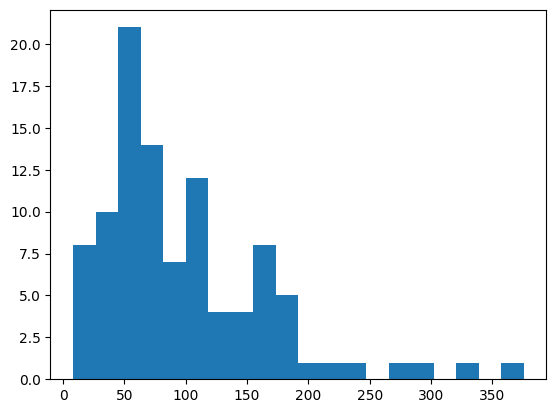

In [23]:
# Plot the trip distances in a histogram
plt.hist(aggregator.assigned_trips_dataframe()['trip_length'], bins=20)
plt.show()